/software/lsstsw/stack3_20171023/python/miniconda3-4.3.21/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in log10
/software/lsstsw/stack3_20171023/python/miniconda3-4.3.21/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in log10


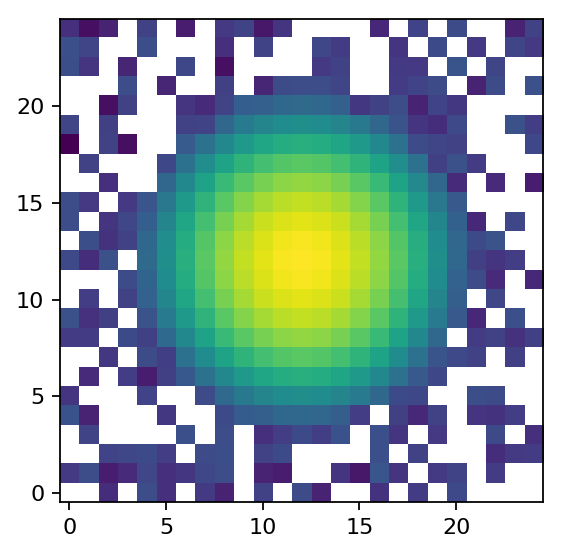

In [1]:
# Test what happens if one fits a galaxy model with a pixel-convolved PSF at 
# two different spatial (pixel) scales

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pyprofit.python.objects as proobj
import pyprofit.python.util as proutil
import galsim as gs

mpl.rcParams['figure.dpi'] = 160
mpl.rcParams['image.origin'] = 'lower'

nx = 200
ny = nx

# 1000 counts/pixel
background = 1e3

# Galaxy parameters
nser = 0.5
re = 2
band = ""
# Slightly ludicrous S/N
flux = 10*background*nx*ny

# PSF parameters
fwhm = 4

galaxy = gs.Sersic(flux=flux, n=nser, half_light_radius=re)
psf = gs.Gaussian(flux=1, fwhm=fwhm)

imgpsf = psf.drawImage(nx=25, ny=25, scale=1, method="no_pixel").array
imgpsfnoisy = (np.random.poisson(flux*imgpsf + background) + 0.0).reshape(
    imgpsf.shape)
imgpsfsigma = np.sqrt(imgpsfnoisy)
imgpsfnoisy -= background
plt.imshow(np.log10(imgpsfnoisy))
plt.show()


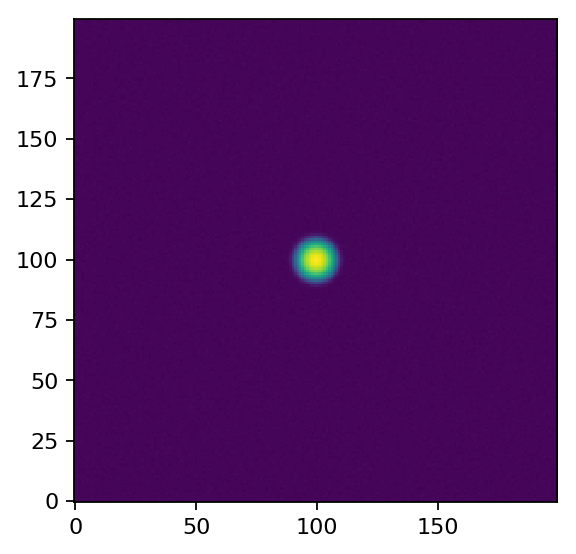

In [2]:
# draw the true galaxy model
modelgal = proutil.getmodel(
        {band: flux}, "sersic:1", (ny, nx),
        sizes=[np.sqrt(re**2 + (fwhm/2)**2)], axrats=[1], slopes=[0.5],
        engineopts={'drawmethod': 'no_pixel', 'gsparams': gs.GSParams()})
proutil.setexposure(modelgal, band, "empty")
eval = modelgal.evaluate(keepimages=True, getlikelihood=False)
imgmodel = np.random.poisson(modelgal.data.exposures[band][0].meta[
    'modelimage']+background)

plt.imshow(np.log10(imgmodel))
plt.show()

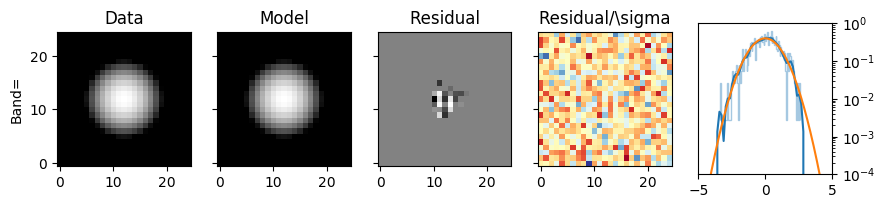

Param names:
 ['re']
Initial parameters:
 [ 0.30103]
Evaluating initial parameters:
 (-878.97516169957646, 0.0)


Optimization terminated successfully.
         Current function value: 877.884704
         Iterations: 26
         Function evaluations: 56
Elapsed time: 0.1
Final likelihood: (-877.88470368863932, 0.0)
Parameter names:        re        
Transformed parameters: 3.0101e-01
['cenx=12.5', 'ceny=12.5', 'flux=400000000.0', 'flux=1.0', 're=1.99992665106', 'axrat=1.0', 'ang=0.0', 'nser=0.5']
Param names:
 ['re']
Initial parameters:
 [ 0.30103]
Evaluating initial parameters:
 (-56972.421028163422, 0.0)


/software/lsstsw/stack3_20171023/python/miniconda3-4.3.21/lib/python3.6/site-packages/scipy/optimize/_minimize.py:394: RuntimeWarning: Method Nelder-Mead cannot handle constraints nor bounds.
  RuntimeWarning)


Optimization terminated successfully.
         Current function value: 56971.229801
         Iterations: 20
         Function evaluations: 42
Elapsed time: 0.2
Final likelihood: (-56971.229800947418, 0.0)
Parameter names:        re        
Transformed parameters: 3.0106e-01


['cenx=100.0', 'ceny=100.0', 'flux=400000000.0', 'flux=1.0', 're=2.00015561408', 'axrat=1.0', 'ang=0.0', 'nser=0.5']


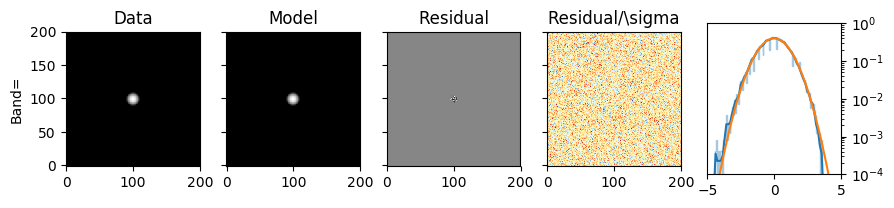

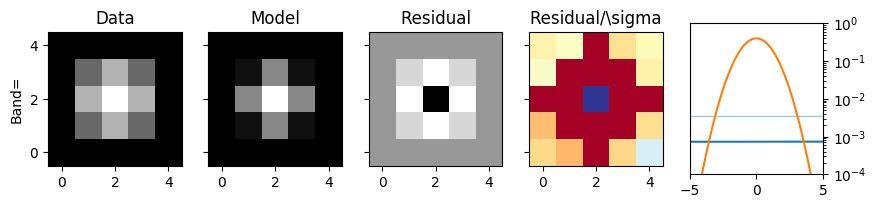

Param names:
 ['re']
Initial parameters:
 [-0.39794001]
Evaluating initial parameters:
 (-132081732.4751009, 0.0)


Optimization terminated successfully.
         Current function value: 1365536.193914
         Iterations: 31
         Function evaluations: 67
Elapsed time: 0.1
Final likelihood: (-1365536.1939137855, 0.0)
Parameter names:        re        
Transformed parameters: -2.7964e-01
['cenx=2.5', 'ceny=2.5', 'flux=400000000.0', 'flux=1.0', 're=0.525247013886', 'axrat=1.0', 'ang=0.0', 'nser=0.5']
Param names:
 ['re']
Initial parameters:
 [-0.39794001]
Evaluating initial parameters:
 (-186399.50954883051, 0.0)


Optimization terminated successfully.
         Current function value: 22165.136069
         Iterations: 27
         Function evaluations: 57
Elapsed time: 0.1
Final likelihood: (-22165.136069218504, 0.0)
Parameter names:        re        
Transformed parameters: -4.1764e-01


['cenx=20.0', 'ceny=20.0', 'flux=400000000.0', 'flux=1.0', 're=0.382264505693', 'axrat=1.0', 'ang=0.0', 'nser=0.5']


In [3]:
def downsample(x, scale):
    if scale == 1:
        return x
    return x.reshape((x.shape[0]//scale, scale, x.shape[1]//scale,
                      scale)).sum(3).sum(1)

models = {}
for scale in [1, 5]:
    modelpsf = proutil.getmodel(
        {band: flux}, "sersic:1", [x//scale for x in imgpsf.shape],
        sizes=[fwhm/2/scale], axrats=[1], slopes=[0.5],
        engineopts={'drawmethod': 'no_pixel', 'gsparams': gs.GSParams()})
    for param in modelpsf.getparameters(fixed=False):
        if param.name in ["cenx", "ceny", "nser", "axrat", "ang"]:
            param.fixed = True
        elif isinstance(param, proobj.FluxParameter):
            param.fixed = not param.isfluxratio
    proutil.setexposure(modelpsf, band, downsample(imgpsfnoisy, scale), 
                        1.0/np.sqrt(downsample(imgpsfnoisy+background, scale)))
    modelpsf.evaluate(plot=True)
    plt.show()
    fit, modeller = proutil.fitmodel(
        modelpsf, printfinal=True, modellibopts={
        'algo': 'Nelder-Mead', 'options': {'disp': True}})
    print(["=".join([x.name, str(x.getvalue())]) for x in 
           modelpsf.getparameters(fixed=True)])
    
    modelpsf.getparameters(fixed=True, flatten=False)[0][1][0][0].setvalue(
        1, transformed=False)
    modelgal = proutil.getmodel(
        {band: flux}, "sersic:1", [x//scale for x in imgmodel.shape],
        sizes=[re/scale], axrats=[1], slopes=[nser],
        engineopts={'drawmethod': 'no_pixel', 'gsparams': gs.GSParams()})
    for param in modelgal.getparameters(fixed=False):
        if param.name in ["cenx", "ceny", "nser", "axrat", "ang"]:
            param.fixed = True
        elif isinstance(param, proobj.FluxParameter):
            param.fixed = not param.isfluxratio
    proutil.setexposure(modelgal, band, downsample(imgmodel-background, scale),
                        1.0/np.sqrt(downsample(imgmodel, scale)),
                        psf=proobj.PSF(band, model=modelpsf.sources[0], 
                                       usemodel=True, modelpixelated=True))
    fit, modeller = proutil.fitmodel(
        modelgal, printfinal=True, modellibopts={
        'algo': 'Nelder-Mead', 'options': {'disp': True}})
    modelgal.evaluate(plot=True)
    
    print(["=".join([x.name, str(x.getvalue())]) for x in 
       modelgal.getparameters(fixed=True)])
    